# Demo

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
from config_manager import ConfigManager
from data_access import DataAccess

schema = ConfigManager.get_config('workloadConfig.schema')
table = ConfigManager.get_config('workloadConfig.table')
indexCol = ConfigManager.get_config('workloadConfig.index_col')

bikes = DataAccess().select_to_df(f"SELECT * FROM {schema}.{table}")

# TODO: move to university servers, run at scale

bikes

,_id,bikeid,start_time,duration_minutes,start_station_name,end_station_name,start_latitude,start_longitude,end_latitude,end_longitude
0,615429,329,2014-10-11 13:12:00+03:00,22,Bullock Museum @ Congress & MLK,Capitol Station / Congress & 11th,30.28039,-97.73809,30.27260,-97.74127
1,615430,140,2015-08-08 19:12:00+03:00,12,Republic Square @ Guadalupe & 4th St.,Davis at Rainey Street,30.26774,-97.74692,30.26019,-97.73845
2,615431,220,2015-01-28 18:12:00+02:00,10,City Hall / Lavaca & 2nd,17th & Guadalupe,30.26476,-97.74678,30.27974,-97.74254
3,615432,445,2016-03-28 14:41:52+03:00,92,Rainey St @ Cummings,Rainey St @ Cummings,30.25579,-97.73982,30.25579,-97.73982
4,615433,894,2015-03-07 16:12:00+02:00,44,Rainey St @ Cummings,Rainey St @ Cummings,30.25579,-97.73982,30.25579,-97.73982
...,...,...,...,...,...,...,...,...,...,...
95,615524,523,2017-06-16 12:52:00+03:00,45,Pfluger Bridge @ W 2nd Street,Riverside @ S. Lamar,30.26717,-97.75484,30.26446,-97.75665
96,615525,696,2015-10-19 17:12:14+03:00,13,5th & Bowie,Rainey St @ Cummings,30.26960,-97.75332,30.25579,-97.73982
97,615526,685,2015-09-17 17:12:42+03:00,5,Barton Springs @ Kinney Ave,Zilker Park,30.26200,-97.76118,30.26590,-97.76822
98,615527,518,2016-03-18 15:00:21+02:00,8,Republic Square @ Guadalupe & 4th St.,Red River & 8th Street,30.26774,-97.74692,30.26854,-97.73646


## Query workload

In [17]:
from jaccard_workload_approximator import JaccardWorkloadApproximator

workload_approximator = JaccardWorkloadApproximator()

workload = workload_approximator.run(20)
workloadResults = workload_approximator.results

============ starting iteration 1   ============
Processing query:
SELECT _id FROM public.austin_bikes_100 WHERE end_latitude BETWEEN 30.26641005467501 AND 30.28510405330563
Processing query:
SELECT _id FROM public.austin_bikes_100 WHERE end_station_name IN ('City Hall / Lavaca & 2nd' , 'Trinity & 6th Street' , 'East 11th St. & San Marcos' , 'South Congress & Academy' , '5th & Bowie' , 'Palmer Auditorium' , 'Medina & East 6th' , 'South Congress & Barton Springs at the Austin American-Statesman' , 'Republic Square @ Federal Courthouse Plaza' , 'ACC - Rio Grande & 12th' , 'Red River & 8th Street' , 'Rainey St @ Cummings') AND start_station_name IN ('4th & Congress' , 'Republic Square @ Guadalupe & 4th St.' , '2nd & Congress' , 'Rainey St @ Cummings' , '8th & Guadalupe' , 'Convention Center / 3rd & Trinity' , 'Nueces & 3rd' , 'East 11th St. & San Marcos' , 'ACC - Rio Grande & 12th' , 'Convention Center / 4th St. @ MetroRail' , 'UT West Mall @ Guadalupe' , 'Plaza Saltillo' , 'San Jacinto &

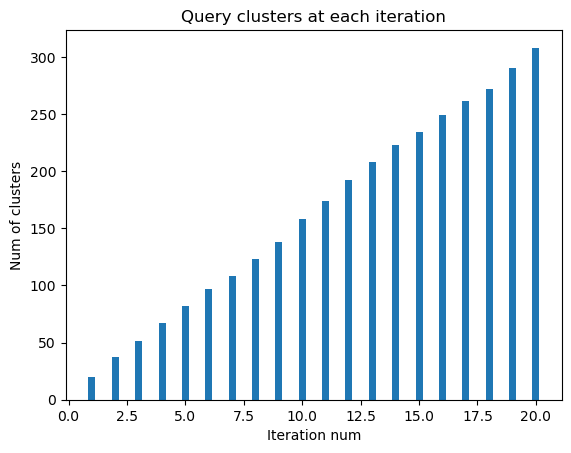

In [18]:
import matplotlib.pyplot as plt

numOfClusters = [{'iter': (i + 1), 'clusters_num': len(workloadResults[i])} for i in range(len(workloadResults))]

iters = [res['iter'] for res in numOfClusters]
clustersNum = [res['clusters_num'] for res in numOfClusters]

plt.bar(iters, clustersNum, 0.3)
plt.xlabel("Iteration num")
plt.ylabel("Num of clusters")
plt.title("Query clusters at each iteration")
plt.show()

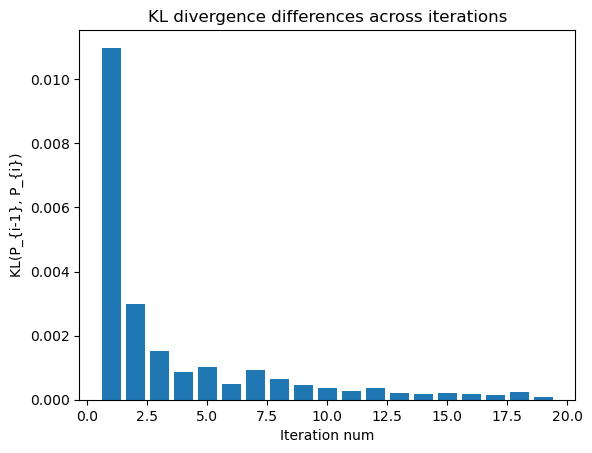

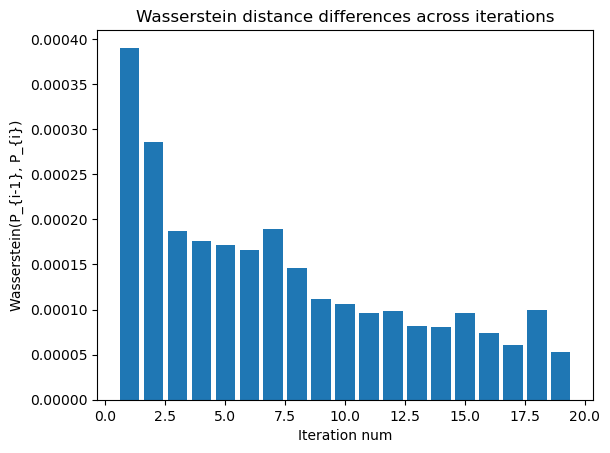

In [19]:
from data_access import DataAccess
from scipy.special import rel_entr
from scipy.stats import wasserstein_distance

dataAccess = DataAccess()
tupleIds = [idObj[indexCol] for idObj in dataAccess.select(f"SELECT {indexCol} FROM {schema}.{table}")]

KL_diff = []
Wasser_diff = []
currDistribution = None
prevDistribution = None

MAX_ITERS_TO_PLOT = 25

iters = [*range(1, len(workloadResults[:MAX_ITERS_TO_PLOT]))]
for iter_num in iters:
    if currDistribution is None:
        prevDistribution = []
        prevApprox = workloadResults[iter_num - 1]
        for tupleId in tupleIds:
            prevDistribution.append(
                sum([cluster['frequency'] for cluster in prevApprox if tupleId in cluster['result']]))
        s = sum(prevDistribution)
        prevDistribution = [p / s for p in prevDistribution]
    else:
        prevDistribution = currDistribution

    currDistribution = []
    approx = workloadResults[iter_num]
    for tupleId in tupleIds:
        currDistribution.append(sum([res['frequency'] for res in approx if tupleId in res['result']]))
    s = sum(currDistribution)
    currDistribution = [p / s for p in currDistribution]

    KL_diff.append(sum(rel_entr(prevDistribution, currDistribution)))
    Wasser_diff.append(wasserstein_distance(prevDistribution, currDistribution))

plt.figure(1)
plt.bar(iters, KL_diff, 0.8)
plt.xlabel("Iteration num")
plt.ylabel("KL(P_{i-1}, P_{i})")
plt.title("KL divergence differences across iterations")

plt.figure(2)
plt.bar(iters, Wasser_diff, 0.8)
plt.xlabel("Iteration num")
plt.ylabel("Wasserstein(P_{i-1}, P_{i})")
plt.title("Wasserstein distance differences across iterations")

plt.show()

## Sample

In [20]:
from saqp_manager import SaqpManager

k = 20
saqp_manager = SaqpManager([query['result'] for query in workload], [query['frequency'] for query in workload])
sample = saqp_manager.get_sample(k)
df = pd.DataFrame(sample)
df

Start running algorithm with budget: 20
Start running LazyGreedy with type UC
============ starting iteration 1   ============
Updated S, new gain: 6364.101253601675529407712665
iteration took: 3462.31 ms
============ starting iteration 2   ============
Updated S, new gain: 6615.435100714477676959145159
iteration took: 5944.32 ms
============ starting iteration 3   ============
Updated S, new gain: 6820.933147709059150855817224
iteration took: 721.08 ms
============ starting iteration 4   ============
Updated S, new gain: 6988.806585105563429160319749
iteration took: 1822.92 ms
============ starting iteration 5   ============
Updated S, new gain: 7146.142850387018495380493114
iteration took: 743.04 ms
============ starting iteration 6   ============
Updated S, new gain: 7275.773218961384525567934111
iteration took: 2443.49 ms
============ starting iteration 7   ============
Updated S, new gain: 7390.213395843905562318790829
iteration took: 1958.53 ms
============ starting iteration 8  

,_id,bikeid,start_time,duration_minutes,start_station_name,end_station_name,start_latitude,start_longitude,end_latitude,end_longitude
0,615458,124,2016-09-11 10:24:45+03:00,10,Convention Center / 4th St. @ MetroRail,City Hall / Lavaca & 2nd,30.26483,-97.73900,30.26476,-97.74678
1,615479,414,2016-05-18 18:31:43+03:00,3,Pfluger Bridge @ W 2nd Street,3rd & West,30.26717,-97.75484,30.26780,-97.75189
2,615464,352,2014-07-18 08:12:00+03:00,29,Capitol Station / Congress & 11th,Capitol Station / Congress & 11th,30.27260,-97.74127,30.27260,-97.74127
3,615523,966,2015-03-18 20:12:00+02:00,4,4th & Congress,Convention Center / 4th St. @ MetroRail,30.26634,-97.74378,30.26483,-97.73900
4,615461,646,2015-12-02 17:12:27+02:00,7,5th & Bowie,Palmer Auditorium,30.26960,-97.75332,30.25971,-97.75346
5,615432,445,2016-03-28 14:41:52+03:00,92,Rainey St @ Cummings,Rainey St @ Cummings,30.25579,-97.73982,30.25579,-97.73982
6,615448,893,2016-09-30 15:38:03+03:00,36,2nd & Congress,2nd & Congress,30.26408,-97.74355,30.26408,-97.74355
7,615446,373,2016-06-12 18:38:54+03:00,13,Convention Center / 4th St. @ MetroRail,Davis at Rainey Street,30.26483,-97.73900,30.26019,-97.73845
8,615442,263,2017-01-29 11:04:39+02:00,54,South Congress & Academy,South Congress & Barton Springs at the Austin ...,30.25226,-97.74854,30.25839,-97.74592
9,615485,712,2015-07-31 14:12:00+03:00,5,4th & Congress,5th & Bowie,30.26634,-97.74378,30.26960,-97.75332


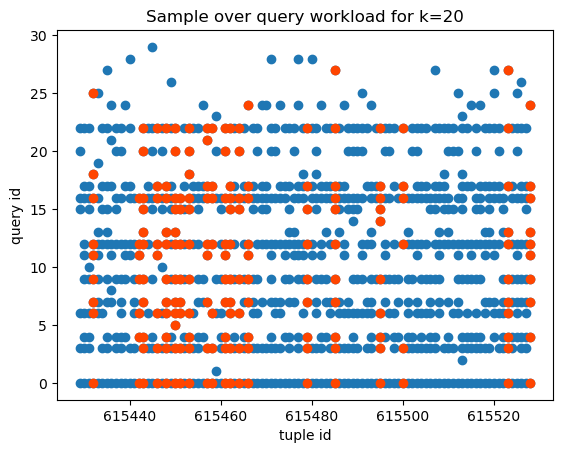

In [21]:
import matplotlib.pyplot as plt
import random

DEFAULT_DOT_SIZE = 5
NUM_OF_QUERIES_TO_PLOT = 30

flat = lambda l: [item for sublist in l for item in sublist]
queries_indices = random.sample([*range(len(workload))], 10)
y = flat([[i] * len(workload[i]['result']) for i in range(NUM_OF_QUERIES_TO_PLOT)])
x = flat([workload[i]['result'] for i in range(NUM_OF_QUERIES_TO_PLOT)])

sampleIds = [tup[indexCol] for tup in sample]
x_sample = [t for t in x if t in set(sampleIds)]
y_sample = [y[i] for i in range(len(y)) if x[i] in set(sampleIds)]
# sizes = flat([[DEFAULT_DOT_SIZE * workload[i]['frequency']] * len(workload[i]['result']) for i in range(NUM_OF_QUERIES_TO_PLOT)])

plt.scatter(x, y)
plt.scatter(x_sample, y_sample, color='#FF4500')
plt.title(f"Sample over query workload for k={k}")
plt.xlabel("tuple id")
plt.ylabel("query id")
plt.show()

## Score on Train vs Test set

In [22]:
maxTestIters = ConfigManager.get_config('testConfig.max_test_iters')
testWorkload = workload_approximator.run(maxTestIters)
testWorkloadResults = workload_approximator.results

testQueryResults = [query['result'] for query in testWorkload]
testQueryWeights = [query['frequency'] for query in testWorkload]
test_saqp_manager = SaqpManager(testQueryResults, testQueryWeights)

test_score_func = SaqpManager.get_test_score_func([query['result'] for query in testWorkload],
                                                  [query['frequency'] for query in testWorkload])
train_score_func = SaqpManager.get_test_score_func([query['result'] for query in workload],
                                                  [query['frequency'] for query in workload])
# train_score_func = saqp_manager.saqpParAdapter.get_gain_function()

============ starting iteration 1   ============
Processing query:
SELECT _id FROM public.austin_bikes_100 WHERE start_station_name IN ('Long Center @ South 1st & Riverside' , 'City Hall / Lavaca & 2nd' , 'ACC - Rio Grande & 12th' , 'East 11th St. & San Marcos' , 'East 4th & Chicon')
Processing query:
SELECT _id FROM public.austin_bikes_100 WHERE start_longitude BETWEEN -97.75780716180742 AND -97.72458832374643 AND start_latitude BETWEEN 30.249145505439152 AND 30.277171654659305
Processing query:
SELECT _id FROM public.austin_bikes_100 WHERE start_latitude BETWEEN 30.250948154220122 AND 30.26419808467348 AND start_longitude BETWEEN -97.75014226104001 AND -97.73472719944836 AND end_latitude BETWEEN 30.254002548380736 AND 30.278728358367115
Processing query:
SELECT _id FROM public.austin_bikes_100 WHERE duration_minutes BETWEEN 84.45611415835923 AND 250.0112285933773 AND start_latitude BETWEEN 30.277734131470694 AND 30.27990506881873
Processing query:
SELECT _id FROM public.austin_bikes_

In [23]:
k_values = [*range(10, 60, 10)]

print('starting train samples')
train_samples_to_k = [saqp_manager.get_sample(k, print_debug_logs=False) for k in k_values]

print('starting test samples')
optimum_samples_to_k = [test_saqp_manager.get_sample(k, print_debug_logs=False) for k in k_values]

starting train samples
Start running algorithm with budget: 10
PAR algorithm took: 40394.66 ms
Start running algorithm with budget: 20
PAR algorithm took: 63582.55 ms
Start running algorithm with budget: 30
PAR algorithm took: 76131.80 ms
Start running algorithm with budget: 40
PAR algorithm took: 89870.93 ms
Start running algorithm with budget: 50
PAR algorithm took: 105131.53 ms
starting test samples
Start running algorithm with budget: 10
PAR algorithm took: 44838.25 ms
Start running algorithm with budget: 20
PAR algorithm took: 64196.37 ms
Start running algorithm with budget: 30
PAR algorithm took: 75813.64 ms
Start running algorithm with budget: 40
PAR algorithm took: 88523.38 ms
Start running algorithm with budget: 50
PAR algorithm took: 92623.01 ms


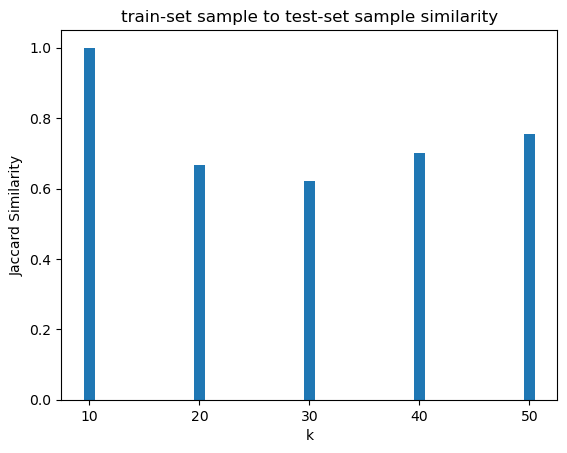

In [24]:
similarities = [workload_approximator.similarity([obj[indexCol] for obj in optimum_samples_to_k[i]],
                                                 [obj[indexCol] for obj in train_samples_to_k[i]]) for i in range(len(k_values))]

plt.bar(k_values, similarities, 1)

plt.xlabel("k")
plt.ylabel("Jaccard Similarity")
plt.title("train-set sample to test-set sample similarity")
plt.show()

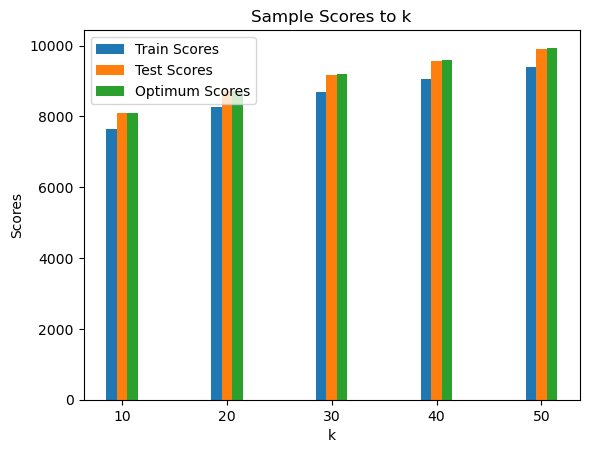

In [29]:
train_scores = [train_score_func(S) for S in train_samples_to_k]
test_scores = [test_score_func(S) for S in train_samples_to_k]
optimum_scores = [test_score_func(S) for S in optimum_samples_to_k]

plt.bar([t - 1 for t in k_values], train_scores, 1, label='Train Scores')
plt.bar(k_values, test_scores, 1, label='Test Scores')
plt.bar([t + 1 for t in k_values], optimum_scores, 1, label='Optimum Scores')

plt.xlabel("k")
plt.ylabel("Scores")
plt.title("Sample Scores to k")
plt.legend()
plt.show()

In [26]:
iters = [*range(maxTestIters)]

trainResultsAndWeights = [
    ([query['result'] for query in workloadResults[i]],
     [query['frequency'] for query in workloadResults[i]])
    for i in iters]

testResultsAndWeights = [
    ([query['result'] for query in testWorkloadResults[i]],
     [query['frequency'] for query in workloadResults[i]])
    for i in iters]

print('starting train samples')
samples = [SaqpManager(trainResultsAndWeights[i][0], trainResultsAndWeights[i][1]).get_sample(k, print_debug_logs=False) for i in iters]

print('starting test samples')
optimum_samples = [SaqpManager(testResultsAndWeights[i][0], testResultsAndWeights[i][1]).get_sample(k, print_debug_logs=False) for i in iters]

starting train samples
Start running algorithm with budget: 20
PAR algorithm took: 15832.24 ms
Start running algorithm with budget: 20
PAR algorithm took: 18286.11 ms
Start running algorithm with budget: 20
PAR algorithm took: 19858.67 ms
Start running algorithm with budget: 20
PAR algorithm took: 20285.38 ms
Start running algorithm with budget: 20
PAR algorithm took: 21872.66 ms
Start running algorithm with budget: 20
PAR algorithm took: 22362.40 ms
Start running algorithm with budget: 20
PAR algorithm took: 24387.18 ms
Start running algorithm with budget: 20
PAR algorithm took: 25365.13 ms
Start running algorithm with budget: 20
PAR algorithm took: 26442.94 ms
Start running algorithm with budget: 20
PAR algorithm took: 29775.06 ms
Start running algorithm with budget: 20
PAR algorithm took: 31070.28 ms
Start running algorithm with budget: 20
PAR algorithm took: 32756.41 ms
Start running algorithm with budget: 20
PAR algorithm took: 35448.53 ms
Start running algorithm with budget: 20
P

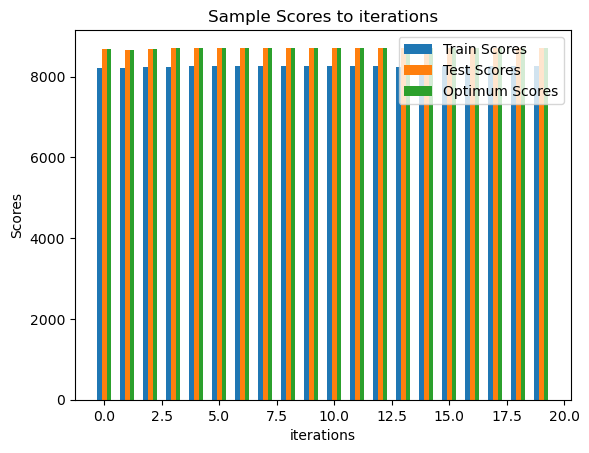

In [27]:
train_scores = [train_score_func(S) for S in samples]
test_scores = [test_score_func(S) for S in samples]
optimum_scores = [test_score_func(S) for S in optimum_samples]

plt.bar([t - 0.2 for t in iters], train_scores, 0.2, label='Train Scores')
plt.bar(iters, test_scores, 0.2, label='Test Scores')
plt.bar([t + 0.2 for t in iters], optimum_scores, 0.2, label='Optimum Scores')

plt.xlabel("iterations")
plt.ylabel("Scores")
plt.title("Sample Scores to iterations")
plt.legend()
plt.show()

In [ ]:
# =========================================================

In [18]:
random_sample = DataAccess().select(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")
df2 = pd.DataFrame(random_sample)

In [19]:
import kmedoids
import numpy as np
from scipy.spatial.distance import pdist, squareform

population = saqp_manager.saqpParAdapter.get_population()


def np_dist(t1, t2):
    keys = [*population[0].keys()]
    t1_dict = {}
    t2_dict = {}
    for i in range(len(t1)):
        t1_dict[keys[i]] = t1[i]
        t2_dict[keys[i]] = t2[i]
    return saqp_manager.saqpParAdapter._dist(t1_dict, t2_dict)


T = np.array([[*d.values()] for d in saqp_manager.saqpParAdapter.get_population()])
distmatrix = squareform(pdist(T, np_dist))
km = kmedoids.fasterpam(distmatrix, saqp_manager.k)
kmedoids_sample = [population[i] for i in list(km.medoids)]
df3 = pd.DataFrame(kmedoids_sample)

In [16]:
score_func = saqp_manager.saqpParAdapter.get_gain_function()
print(f"Sample score for our sample: {score_func(sample)}")

numRandomTrials = 100
random_score = sum(
    [score_func(DataAccess().select(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")) for i
     in range(numRandomTrials)]) / numRandomTrials

# TODO print min and max for random
# TODO change kmedoids by multiplying the points by their weight
# TODO add a graph showing sample scores w.r.t to k (sample size) (test queries or train queries?)
# TODO add graphs showing sample score (w.r.t to train and test) of our sample and runtime w.r.t to num of queries in train set (fixed sample size) - do this after KL


print(f"Sample score for random sample: {random_score}")
print(f"Sample score for kmedoids sample: {score_func(kmedoids_sample)}")  # TODO: look at this more closely again
# TODO add random greedy that in each batch of queries chooses the x tuple with the most cumulative weight until S is full - DO THIS LATER

Sample score for our sample: 23453.82599045498760865315797
Sample score for random sample: 22426.63794223579797109131892
Sample score for kmedoids sample: 22408.59721315035007074243711


In [ ]:
# TODO partition queries to train-test

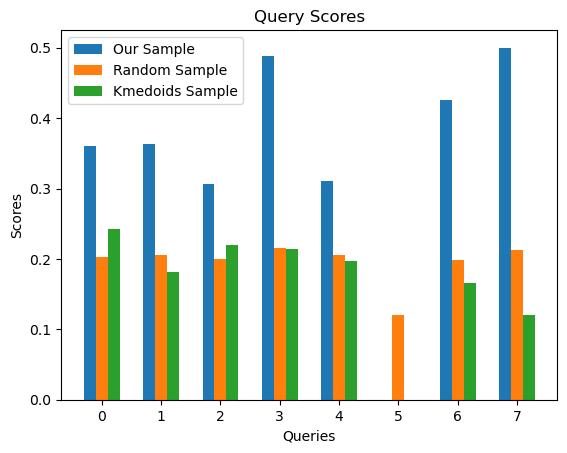

In [119]:
import pandasql as ps
import matplotlib.pyplot as plt

dataAccess = DataAccess()
queries = [q['sql'][0].replace("_id", "*") for q in workload]
x = [*range(len(queries))]

sampleY = []
randomY = []
kmedoidsY = []
for query in queries:
    sample_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df"))
    kmedoids_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df3"))

    sampleY += [saqp_manager.saqpParAdapter.query_result_score(sample_query_df.to_dict('records'),
                                                               dataAccess.select_to_df(query).to_dict('records'))]
    random_dfs = [DataAccess().select_to_df(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")
                  for i in range(numRandomTrials)]
    random_scores = []
    for random_df in random_dfs:
        random_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "random_df"))
        random_scores += [saqp_manager.saqpParAdapter.query_result_score(random_query_df.to_dict('records'),
                                                                         dataAccess.select_to_df(query).to_dict(
                                                                             'records'))]
    randomY += [(sum(random_scores) / numRandomTrials)]
    kmedoidsY += [saqp_manager.saqpParAdapter.query_result_score(kmedoids_query_df.to_dict('records'),
                                                                 dataAccess.select_to_df(query).to_dict('records'))]

plt.bar([t - 0.2 for t in x], sampleY, 0.2, label='Our Sample')
plt.bar([t for t in x], randomY, 0.2, label='Random Sample')
plt.bar([t + 0.2 for t in x], kmedoidsY, 0.2, label='K-medoids Sample')

plt.xlabel("Queries")
plt.ylabel("Scores")
plt.title("Query Scores")
plt.legend()
plt.show()

# TODO: new graphs - showing progress after each batch
# KL/Wasserstein of tuple weights after each batch (comparing each observed distribution to the next) - do this once with threshold=1 (union only when the same) and once with lower threshold
# A graph that shows the score of S at each new batch, score computed w.r.t to test queries (the same test after each batch)
# A graph that shows the score of S at each new batch, score computed w.r.t to the train queries (the same test after each batch)
# Graph showing number of clusters after each batch

In [ ]:
# TODO: test size should about 50

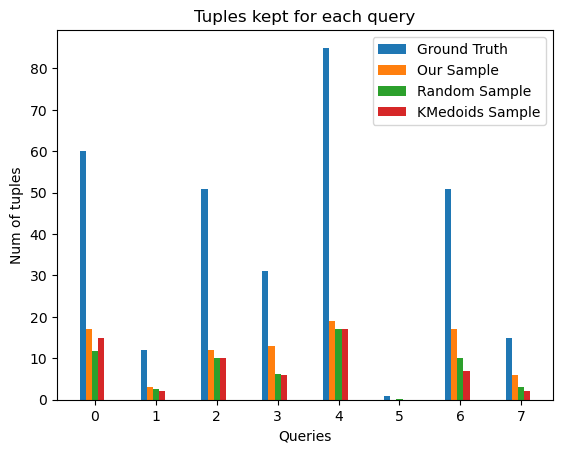

In [120]:
import pandasql as ps
import matplotlib.pyplot as plt

dataAccess = DataAccess()
queries = [q['sql'][0].replace("_id", "*") for q in workload]
x = [*range(len(queries))]

sampleY = []
randomY = []
kmedoidsY = []
truthY = []

# TODO: show num of tuples / 20 and change this to test set

for query in queries:
    sample_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df"))
    kmedoids_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df3"))
    truth_query_df = dataAccess.select_to_df(query)

    random_dfs = [DataAccess().select_to_df(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")
                  for i in range(numRandomTrials)]
    random_scores = []
    for random_df in random_dfs:
        random_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "random_df"))
        random_scores += [len(random_query_df)]

    randomY += [(sum(random_scores) / numRandomTrials)]
    sampleY += [len(sample_query_df.index)]
    kmedoidsY += [len(kmedoids_query_df.index)]
    truthY += [len(truth_query_df.index)]

plt.bar([t - 0.2 for t in x], truthY, 0.1, label='Ground Truth')
plt.bar([t - 0.1 for t in x], sampleY, 0.1, label='Our Sample')
plt.bar([t for t in x], randomY, 0.1, label='Random Sample')
plt.bar([t + 0.1 for t in x], kmedoidsY, 0.1, label='K-medoids Sample')

plt.xlabel("Queries")
plt.ylabel("Num of tuples")
plt.title("Tuples kept for each query")
plt.legend()
plt.show()